# Grover Algorithm
### by Matteo Aguiari

## 1. Setup

In [1]:
%pip install qiskit
%pip install qiskit_aer
%pip install pylatexenc
%pip install qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=4cd98efd91140623498252b2bb2e6adf6ea84e7b7b1d84cb8207d49d11503e2a
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex, circuit_drawer
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.circuit import Gate
from qiskit.quantum_info import Statevector

import math
import numpy as np
import random
import matplotlib.pyplot as plt
from typing import Iterable

In [4]:
sim = AerSimulator()

In [5]:
# ------------------------------------------------------------------
#   Helper functions
# ------------------------------------------------------------------
def generate_bitstrings(n_bits: int, M: int,
                        seed: int | None = None) -> list[str]:
    if n_bits <= 0:
        raise ValueError("n_bits must be >= 1")
    N = 2 ** n_bits
    if M < 0 or M > N:
        raise ValueError(f"M must be in [0, {N}] (with n_bits={n_bits})")

    rng = random.Random(seed)
    indices = rng.sample(range(N), M)

    return [format(i, f"0{n_bits}b") for i in indices]

def ints_to_bitstrings(values: Iterable[int], n_bits: int | None = None) -> list[str]:
    vals = list(values)

    for v in vals:
        if not isinstance(v, int):
            raise TypeError(f"Not an int: {v!r}")
        if v < 0:
            raise ValueError(f"Negative value not allowed: {v}")

    if n_bits is None:
        return [bin(v)[2:] for v in vals]
    else:
        if n_bits <= 0:
            raise ValueError("n_bits must be >= 1")
        max_val = (1 << n_bits) - 1
        for v in vals:
            if v > max_val:
                raise ValueError(f"{v} can't fit in {n_bits} bits (max {max_val}).")
        return [format(v, f"0{n_bits}b") for v in vals]

## 2. Grover Oracle

Define a boolean function that is 1 on the good elements and 0 on the others.
$$
f : \{0,1\}^n \rightarrow \{0,1\}
$$




We want a unitary oracle $U_f$ such that
$$
U_f |x \rangle | q \rangle = |x \rangle | q \oplus f(x)  \rangle  
$$
In this equation, $x$ is an $n$-qubit regiter and $q$ is a single ancilla qubit. \
When the value of $x$ is our target, we want to mark the ancilla qubit by flipping its phase. \

We need to figure out a state $q$ that has such a property: it turns out that what we are looking for is the state $|-\rangle = \frac{|0\rangle - |1\rangle}{\sqrt{2}}$.
When $f(x)=1$ the oracle applies $X$ on q, but since $|-\rangle$ is an eigenstate of such operator, the result is $X|-\rangle = - |-\rangle$, so
$$
U_f |x \rangle | - \rangle = (-1)^{f(x)} |x \rangle | - \rangle
$$

In [6]:
def GroverOracleGate(marked_bitstrings: list[str]) -> Gate:
  if not marked_bitstrings:
        raise ValueError("marked_bitstrings cannot be empty")

  n = len(marked_bitstrings[0])
  if any(len(s) != n for s in marked_bitstrings):
    raise ValueError("All bitstring must have the same lenght")

  qc = QuantumCircuit(n+1, name=f"Oracle_M={len(marked_bitstrings)}")
  oracle_qubit = n

  for target in marked_bitstrings:
    for i, bit in enumerate(reversed(target)):
      if bit == '0':
        qc.x(i)

    qc.mcx(list(range(n)), oracle_qubit)

    for i, bit in enumerate(reversed(target)):
      if bit == '0':
        qc.x(i)

  return qc.to_gate()

## TEST IT!
Change the variables in the box below to draw the oracle circuit associated to those parameters

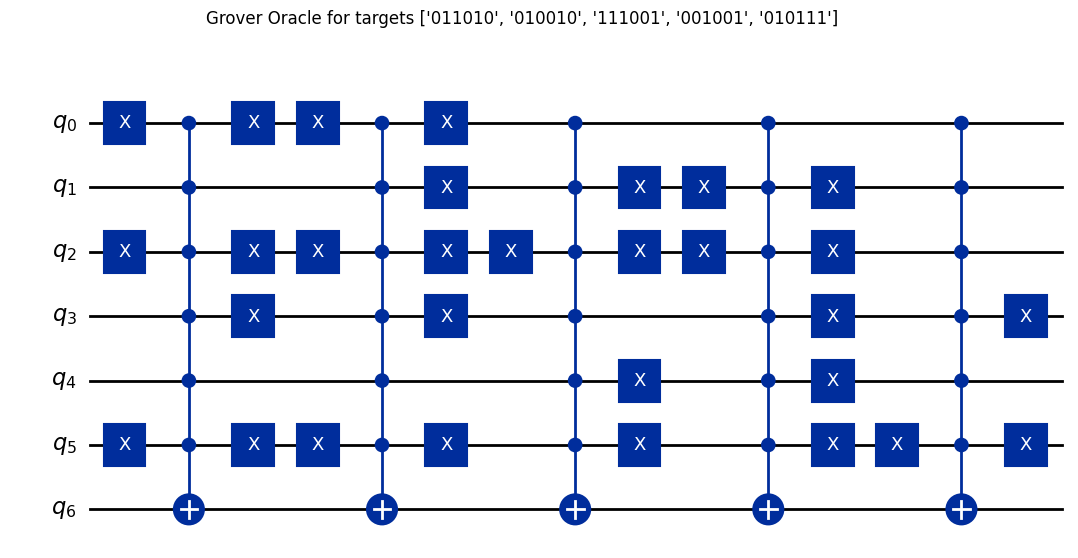

In [7]:
# Insert all the targets you like (all of same bit length)
targets = ['011010', '010010', '111001', '001001', '010111']


oracle_gate = GroverOracleGate(targets)
oracle_circuit = oracle_gate.definition
fig = oracle_circuit.draw("mpl", fold=-1)
fig.suptitle(f"Grover Oracle for targets {targets}")
display(fig)
plt.close(fig)

## 3. Grover Diffuser

The function of this gate is to mark with a minus sign all the qubits except $|0⟩$ and go back on the computational basis.

The procedure is the following:


*   $H^{⊗n}$
*   $|x⟩ → -(-1)^{δ_{x,0}}|x⟩$
*   $H^{⊗n}$



In [8]:
def GroverGate(n: int) -> Gate:
    qc = QuantumCircuit(n, name='Grover')

    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(list(range(n-1)), n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))

    return qc.to_gate()

## TEST IT!
Change the variables in the box below to draw the Grover Diffuser circuit associated to those parameters

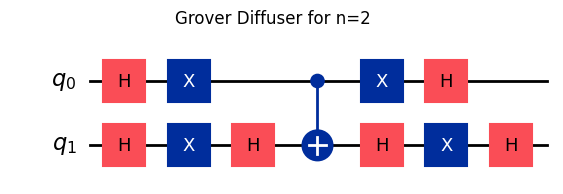

In [9]:
# Select the number of qubits you are working with
n = 2


grover_gate = GroverGate(n)
grover_circuit = grover_gate.definition
fig = grover_circuit.draw("mpl", fold=-1)
fig.suptitle(f"Grover Diffuser for n={n}")
display(fig)
plt.close(fig)

## 4. Grover circuit
Starting from $|Ψ⟩ = |0⟩^{⊗ n+1}$, we want to apply the Grover gate, which is a concatenation of the Oracle and the Diffuser, $k$ times.

Each application of the Grover gate can be analitically expressed as:
$$
G = (2|Ψ⟩⟨Ψ| - I)U_f
$$

In [10]:
def GroverCircuit(n: int, targets: list[str],
                  k: int,
                  measure: bool = True,
                  decompose_blocks: bool = False) -> QuantumCircuit:
    Uf = GroverOracleGate(targets)
    G  = GroverGate(n)

    qc = QuantumCircuit(n+1, n if measure else 0)

    qc.h(range(n))
    qc.x(n)
    qc.h(n)

    qc.barrier()

    for _ in range(k):
        qc.append(Uf, list(range(n+1)))
        qc.append(G,  list(range(n)))
        qc.barrier()

    if measure:
      qc.measure(range(n), range(n))

    if decompose_blocks:
      qc = qc.decompose(reps=10)

    return qc


## TEST IT!
Change the variables in the box below to draw the Grover circuit associated to those parameters

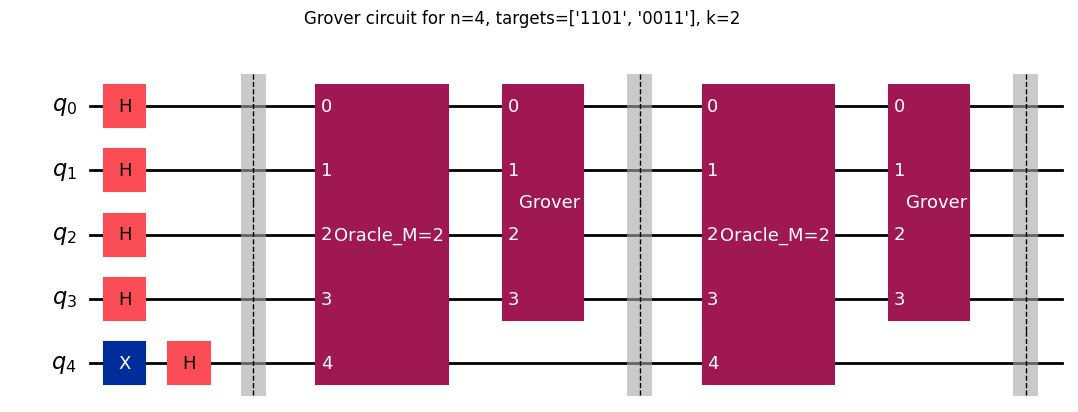

In [11]:
targets = ["1101", "0011"]
n = len(targets[0])
k = 2

qc = GroverCircuit(n, targets, k, measure=False)
fig = qc.draw("mpl", fold=-1)
fig.suptitle(f"Grover circuit for n={n}, targets={targets}, k={k}")
display(fig)
plt.close(fig)

## 5. Geometrical interpretation

The aplication of the Grover gate can be seen as the rotation of an angle $θ$ in the $α/\beta$ plain.
Alpha e beta are defined as the superposition of the non solutions and the solutions, respectively, as follows:
$$
|\alpha⟩ = \frac{1}{\sqrt{N-M}} \sum_{x=\text{not sol}} |x⟩
$$

$$
|β⟩ = \frac{1}{\sqrt{M}} \sum_{x=\text{sol}} |x⟩
$$

The initial state can be expressed as

$$
|\psi⟩ = \sqrt{\frac{N-M}{N}}|α⟩ + \sqrt{\frac{M}{N}}|β⟩
$$


After the application of the gate for $k$ times, it can be written as

$$
G^k|Ψ⟩ = cos \left( \frac{2k+1}{2}θ \right)|α⟩ + sin \left( \frac{2k+1}{2}θ \right)|β⟩
$$

In [12]:
def alpha_beta_decomposition(state_index: Statevector, marked: set[int], n: int) -> set:
    N = 2**n
    M = len(marked)
    amps = state_index.data

    beta = sum(amps[i] for i in marked) / np.sqrt(M)
    unmarked = [i for i in range(N) if not i in marked]
    alpha = sum(amps[i] for i in unmarked) / np.sqrt(N-M)

    p_succ = sum(abs(amps[i])**2 for i in marked)
    return alpha, beta, p_succ

def extract_index_state_given_minus(sv: Statevector, n: int) -> Statevector:
    N = 2**n
    a0 = sv.data[0:N]       # ancilla=0 (ancilla è qubit n => bit più significativo)
    a1 = sv.data[N:2*N]     # ancilla=1
    b = (a0 - a1) / math.sqrt(2)   # proiezione su |->
    norm = np.linalg.norm(b)
    if norm == 0:
        raise ValueError("Norm 0 in projection on |-> (wrong qubit order or circuit).")
    return Statevector(b / norm)

def probs_index_from_full_sv(sv: Statevector, n: int):
    """Marginalizes the ancilla: P(x)=|a_{x,0}|^2+|a_{x,1}|^2"""
    N = 2**n
    a0 = sv.data[0:N]
    a1 = sv.data[N:2*N]
    return np.abs(a0)**2 + np.abs(a1)**2

def state_for_k(n: int, targets: list[str], k: int) -> Statevector:
  qc = GroverCircuit(n, targets, k, measure=False)
  return Statevector.from_instruction(qc.decompose(reps=10))

def demo(n: int, targets: list[str], max_k: int,
         print_info: bool = False):
    N = 2**n
    M = len(targets)
    marked = {int(t, 2) for t in targets}
    theta = math.asin(math.sqrt(M/N))

    if print_info:
      print(f"n={n}, N={N}, M=1, targets={targets}")
      print(f"theta = {theta:.6f} rad\n")

    probabilities = np.zeros(max_k+1)
    for k in range(max_k+1):
        sv = state_for_k(n, targets, k)

        p_index = probs_index_from_full_sv(sv, n)
        top = int(np.argmax(p_index))

        sv_x = extract_index_state_given_minus(sv, n)
        alpha, beta, p_succ = alpha_beta_decomposition(sv_x, marked, n)
        probabilities[k] = p_succ

        phase = np.exp(-1j * np.angle(beta))
        alpha_r = (alpha * phase).real
        beta_r  = (beta  * phase).real
        phi = math.atan2(beta_r, alpha_r)

        p_theory = math.sin((2*k+1)*theta)**2
        phi_theory = (2*k+1)*theta

        if print_info:
          print(f"k={k:2d}  P(sim)={p_succ:.6f} P(th)={p_theory:.6f}  "
                f"alpha={alpha_r:.6f} beta={beta_r:.6f}  phi={phi:.6f}  "
                f"TOP={top:0{n}b}")

    return probabilities

def GroverStatevector(n: int, oracle: Gate, grover_gate: Gate, k: int) -> Statevector:
  qc = QuantumCircuit(n+1)

  qc.h(range(n))
  qc.x(n)
  qc.h(n)

  for _ in range(k):
    qc.append(oracle, list(range(n+1)))
    qc.append(grover_gate, list(range(n)))

  return Statevector.from_instruction(qc.decompose(reps=10))


def alpha_beta_sequence_continuous_phase(n: int, M: int, ks: list[int],
                                         targets: list[str] | None):
    if targets is None:
      targets = generate_bitstrings(n, M)
      print(f"Generated indeces: {targets}")

    oracle_gate = GroverOracleGate(targets)
    diffuser_gate = GroverGate(n)
    marked = {int(t, 2) for t in targets}

    out = []
    v_prev = None

    for k in ks:
        full_sv = GroverStatevector(n, oracle_gate, diffuser_gate, k)
        sv_x = extract_index_state_given_minus(full_sv, n)
        alpha, beta, p = alpha_beta_decomposition(sv_x, marked, n)

        v = np.array([alpha, beta], dtype=complex)

        if v_prev is None:
            phase = np.exp(-1j * np.angle(v[0]))
        else:
            phase = np.exp(-1j * np.angle(np.vdot(v_prev, v)))

        v = v * phase
        alpha_r, beta_r = v.real
        out.append({"k": k, "alpha": float(alpha_r), "beta": float(beta_r), "p": float(p)})
        v_prev = v

    return out

def plot_psi_alpha_beta(n: int, M: int, max_k: int,
                        targets: list[str] | None,
                        annotate: bool = True):
  if targets is None:
      targets = generate_bitstrings(n, M)
      print(f"Generated indeces: {targets}")

  ks = list(range(0, max_k+1))
  data = alpha_beta_sequence_continuous_phase(n, M, ks, targets)

  alphas = [d["alpha"] for d in data]
  betas  = [d["beta"] for d in data]

  fig, ax = plt.subplots()
  t = np.linspace(0, 2*np.pi, 400)
  ax.plot(np.cos(t), np.sin(t), linestyle='--', linewidth=1)

  ax.quiver(
      np.zeros_like(alphas), np.zeros_like(betas),
      alphas, betas,
      angles='xy', scale_units='xy', scale=1,
      width=0.006
  )

  if annotate:
    for d in data:
      ax.text(d["alpha"], d["beta"], f"{d["k"]}", fontsize=9, ha="left", va="bottom")

  ax.set_xlabel("α  (non-match)")
  ax.set_ylabel("β  (match)")
  ax.set_title(f"α-β trajectory (n={n}, M={len(targets)})")
  ax.set_aspect("equal", adjustable="box")
  ax.grid(True)
  plt.show()


## TEST IT!
Change the variables in the box below to see the rotation of the state on the $α/β$ plain after each application of $k$.

REMEMBER: the goal is to achieve $|Ψ\rangle ≈|β⟩$

Generated indeces: ['1110111110', '1001101101', '0010110111', '0000000011', '1100110111', '0111100001', '0101001100', '1101010111', '1111111101']


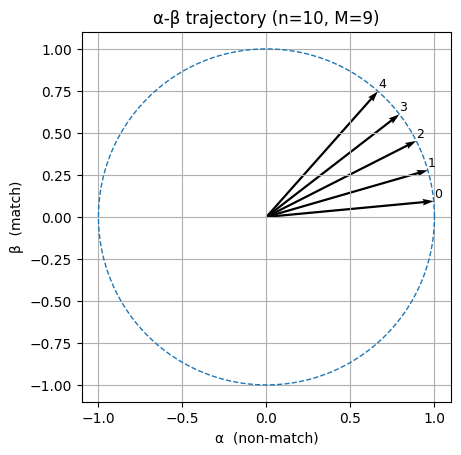

In [13]:
n = 10
M = 9
max_k = 4
targets = None
annotate = True

plot_psi_alpha_beta(n, M, max_k, targets, annotate=annotate)

## 6. Complexity speedup

The clasical search algorithm of M solutions in a dataset of N elements has a computational complexity which scales with $\mathcal{O}(\frac{N}{M})$.

The quantum version, namely the Grover algorithm instead, scales much faster, as $\mathcal{O}(\sqrt{\frac{N}{M}})$. This understood logically thanks to the geometrical interpretation discussed above.

In [15]:
def classical_query(N: int, marked: list[int], rng: np.random.Generator) -> int:
  q = 0
  while True:
    q += 1
    x = int(rng.integers(0, N, dtype=int))
    if x in marked:
      return q

def grover_query(n: int, marked_bits: list[str], k: int,
                 sim: AerSimulator, rng: np.random.Generator) -> int:
    marked_set = {int(m, 2) for m in marked_bits}

    qc = GroverCircuit(n, marked_bits, k, measure=True)  # PASSA BITSTRING, non set
    tqc = transpile(qc, sim, optimization_level=1)

    total_q = 0
    while True:
        total_q += k
        result = sim.run(tqc, shots=1).result()
        counts = result.get_counts()
        bitstr = next(iter(counts.keys()))  # FIX
        measured = int(bitstr, 2)
        if measured in marked_set:
            return total_q


def plot_complexity(n_values: list[int], M: int,
                    trials: int = 50,
                    seed: int = 0):
    rng = np.random.default_rng(seed)
    sim = AerSimulator()  # FIX

    Ns = []
    classic_means, classic_stds = [], []
    grover_means, grover_stds = [], []

    for n in n_values:
        N = 2**n
        if M > N:
            raise ValueError(f"M={M} > N={N} per n={n}")

        marked_bits = generate_bitstrings(n, M)  # lista di bitstring
        marked_set = {int(m, 2) for m in marked_bits}

        theta = math.asin(math.sqrt(M / N))
        k = int(max(0, round((math.pi / (4 * theta)) - 0.5)))

        cls = np.array([classical_query(N, marked_set, rng) for _ in range(trials)], dtype=float)
        classic_means.append(float(cls.mean()))
        classic_stds.append(float(cls.std(ddof=1)))

        if k == 0:
            gr = np.zeros(trials, dtype=float)
        else:
            gr = np.array([grover_query(n, marked_bits, k, sim, rng) for _ in range(trials)], dtype=float)

        grover_means.append(float(gr.mean()))
        grover_stds.append(float(gr.std(ddof=1)))

        Ns.append(N)
        print(f"n={n} N={N} M={M} k_opt={k}  classic_mean={classic_means[-1]:.2f}  grover_mean={grover_means[-1]:.2f}")

    Ns = np.array(Ns, dtype=float)
    classic_means = np.array(classic_means, dtype=float)
    classic_stds = np.array(classic_stds, dtype=float)
    grover_means = np.array(grover_means, dtype=float)
    grover_stds = np.array(grover_stds, dtype=float)

    fig, ax = plt.subplots()
    ax.errorbar(Ns, classic_means, yerr=np.sqrt(classic_stds), marker='o', linestyle='-', capsize=3, label="classical")
    ax.errorbar(Ns, grover_means, yerr=np.sqrt(grover_stds), marker='o', linestyle='--', capsize=3, label="grover")

    # ax.set_xscale("log")
    # ax.set_yscale("log")
    ax.set_xlabel(r"N = $2^n$")
    ax.set_ylabel("Oracle queries")
    ax.set_title(f"Classical VS Grover Complexity (M={M}, trials={trials})")
    ax.grid(True, which="both")
    ax.legend()
    plt.show()

## TEST IT!
Change the variables in the box below to see the speedup achieved using the quantum algorithm.

***Note*** : due to the classical algorithm, this simulation is quite slow, so I suggest small values of N (less than 10).

n=3 N=8 M=7 k_opt=0  classic_mean=1.04  grover_mean=0.00
n=4 N=16 M=7 k_opt=1  classic_mean=2.36  grover_mean=1.38
n=5 N=32 M=7 k_opt=1  classic_mean=3.62  grover_mean=1.00
n=6 N=64 M=7 k_opt=2  classic_mean=8.12  grover_mean=2.04


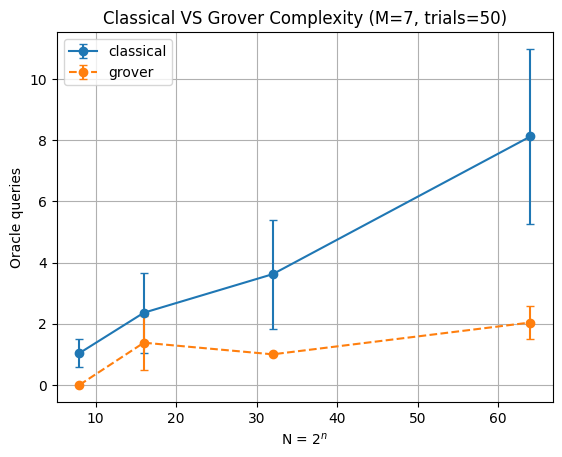

In [16]:
n_begin = 3
n_stop = 6
M = 7
n_values = np.linspace(n_begin, n_stop,
                       n_stop - n_begin + 1, dtype=int)

plot_complexity(n_values, M)

## 7. Play with other simulations

Below you can test some other simulation that allow you to see:
 * How the success probability changes with k and M
 * What is the output of the simulation using different inputs (performed by simulating the measurement on the computational basis)

In [22]:
def plot_success_VS_k(n: int, M: int, max_k: int,
                      targets: list[str] | None,
                      show_info: bool = True):
  if targets is None:
    targets = generate_bitstrings(n, M)
    print(f"Generated indeces: {targets}")

  probabilities = demo(n, targets, max_k=max_k, print_info=show_info)
  k = np.linspace(0, max_k, max_k+1)
  plt.title(f"Success probability for n={n} and M={M}")
  plt.xlabel("Number of Grover gate application")
  plt.ylabel("Success probability")
  plt.plot(k, probabilities)

def plot_outcomes_histo(n: int, M: int, k: int,
                        targets: list[str] | None):
  if targets is None:
    targets = generate_bitstrings(n, M)
    print(f"Generated indeces: {targets}")

  qc = GroverCircuit(n, targets, k, True, False)
  tqc = transpile(qc, sim, optimization_level=1)
  counts = sim.run(tqc, shots=5000).result().get_counts()
  fig = plot_histogram(counts, title=f"Grover n={n}, target={targets}, k={k}")
  display(fig)
  plt.close(fig)

def plot_counts_for_ks(n: int, M: int, ks: list[int],
                       targets: list[str] | None):
    fig, axes = plt.subplots(1, len(ks), figsize=(4*len(ks), 6))
    if len(ks) == 1:
        axes = [axes]

    if targets is None:
      targets = generate_bitstrings(n, M)
      print(f"Generated indeces: {targets}")

    for ax, k in zip(axes, ks):
        qc = GroverCircuit(n, targets, k, True, False)
        tqc = transpile(qc, sim, optimization_level=1)
        counts = sim.run(tqc, shots=5000).result().get_counts()
        plot_histogram(counts, ax=ax, title=f"k={k}")

    plt.tight_layout()
    plt.show()

### Success probability VS *k*

Generated indeces: ['10011', '01100']
n=5, N=32, M=1, targets=['10011', '01100']
theta = 0.252680 rad

k= 0  P(sim)=0.062500 P(th)=0.062500  alpha=0.968246 beta=0.250000  phi=0.252680  TOP=00000
k= 1  P(sim)=0.472656 P(th)=0.472656  alpha=0.726184 beta=0.687500  phi=0.758041  TOP=01100
k= 2  P(sim)=0.908447 P(th)=0.908447  alpha=0.302577 beta=0.953125  phi=1.263401  TOP=01100
k= 3  P(sim)=0.961319 P(th)=0.961319  alpha=-0.196675 beta=0.980469  phi=1.768762  TOP=10011
k= 4  P(sim)=0.581704 P(th)=0.581704  alpha=-0.646758 beta=0.762695  phi=2.274122  TOP=01100
k= 5  P(sim)=0.125492 P(th)=0.125492  alpha=-0.935151 beta=0.354248  phi=2.779483  TOP=01100
k= 6  P(sim)=0.020381 P(th)=0.020381  alpha=0.989757 beta=0.142761  phi=0.143251  TOP=00110
k= 7  P(sim)=0.364913 P(th)=0.364913  alpha=0.796924 beta=0.604080  phi=0.648611  TOP=10011
k= 8  P(sim)=0.836089 P(th)=0.836089  alpha=0.404859 beta=0.914379  phi=1.153972  TOP=01100


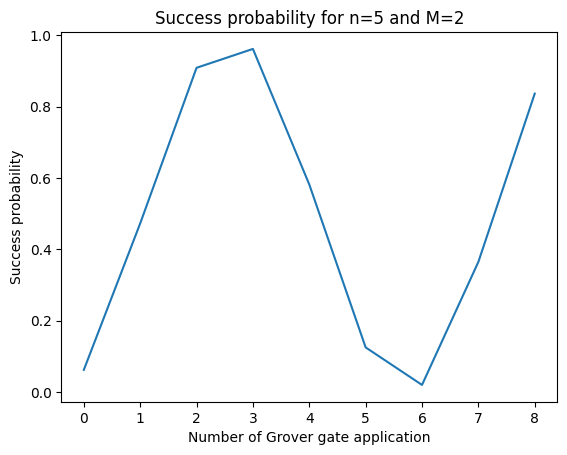

In [18]:
n = 5
M = 2
max_k = 8
targets = None
show_info = True

plot_success_VS_k(n, M, max_k, targets, show_info)

### Measurement outcome after the application of $G^k$

Generated indeces: ['01110', '01000', '01001', '00000', '10001', '01101']


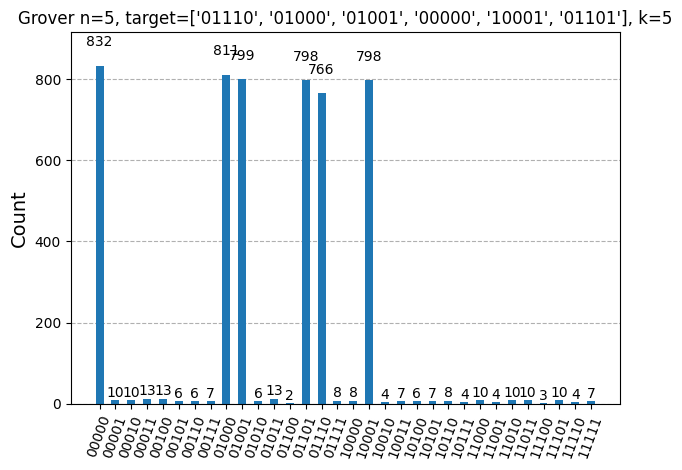

In [19]:
n = 5
M = 6
k = 5
targets = None

plot_outcomes_histo(n, M, k, targets)

### Comparison of measurements outcomes with different *k* values

Generated indeces: ['001', '000']


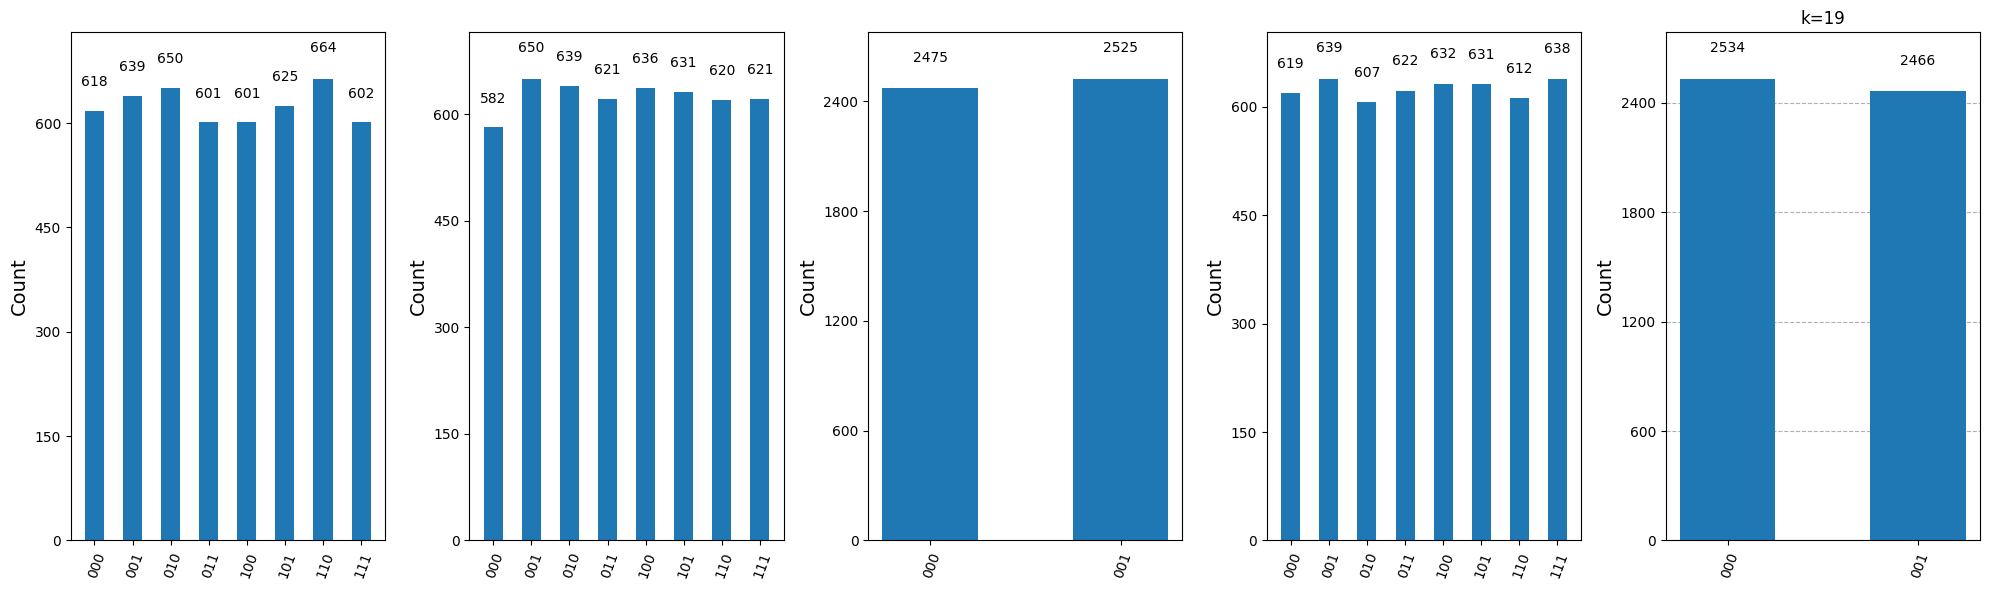

In [23]:
n = 3
M = 2
ks = [0, 5, 7, 12, 19]
targets = None

plot_counts_for_ks(n, M, ks, targets)